# High Level Usage
This notebook shows how to use the most important features of the analysis framework `dramlib` 


In [11]:
from dramlib import DRAMConfigFile
from dramlib.cnn_conv import CNNConv
from dramlib.iss.converter import Converter
from dramlib.dramsys.simulation import Dramsys
from dramlib.dramsys.parsing import Parser as DRAMParser
from dramlib.plotting import Plotter
from os.path import join
from os import listdir

In [12]:
folder = '/home/luismendes/DRAM-Research/dram_analysis/config/'
input_files_folder = join(folder, 'input/')
input_files = [
  join(input_files_folder, file) 
  for file in listdir(input_files_folder)
]
paths_file = join(folder, 'paths/paths_example.json')
paths_file, input_files

# Configuration file
The configuration file is the file used to proceed with all of the parts of the simulation. It defines the paths to every file and system used and created during the analysis process, all the values and variables that can be set in each of the systems and some additional information. 

It can be used to ease the execution of all the parts of the framework.

## Types of config file
Each `input_file.json` generates a certain number of `specific_config.json`, depending on how many values the variable assumes, and one `generic_config.json`. The main difference between those files is that the specific contains only information regarding the execution of a given execution, i.e., the variable assumes a certain value, when the generic contains information about all the different values, e.g, the path to all config files related to that simulation in specific.

## How to create a config file
Running the `dramlib.DRAMConfigFile.start()` it's possible to generate a json config file.

To set the simulation, it's necessary to import 2 files: `input_file.json` and `paths_file.json`. 
### Input File
This file contains parameters about the simulation itself, including:
 - `prefix`: The identifier to the simulation, used only to differ between simulations
 - `platform`: `cnn` or `iss`, the 2 options available to run NNs using the ZuSE KI AVF  system
 - `app`: the name of the app to run
 - `dsys_cfg`: the DRAM (from DRAMSys) subsystem to be used
 - `variable`: the variable to be changed in the different simulations
 - `values`: list with the values that the variable will assume in each simulation
```json
{    
    "params":{
        "prefix": "cluster_example",
        "platform": "cnn",
        "app": "nnqtest_conv1d",
        "dsys_cfg": "ddr4-example.json",
        "variable": "cluster",
        "values": [1, 2, 4, 8, 16]
    }
}
```
### Paths File
File containing the paths for the following systems
 - `dramsys`: DRAMSys repository location
 - `zuse_ki_avf`: ZuSE-KI-AVF repository location
 - `output_data`: The path to the expected output

```json
{
    "paths":{
        "dramsys":"/home/luismendes/DRAMSys/",
        "zuse_avf_ki":"/home/luismendes/zuse_ki_avf/",
        "output_data":"/home/luismendes/DRAM-Research/output_test_fm_first/"
    }
}
```

In [13]:
def start(input_file, path_file):
    dcf = DRAMConfigFile()
    dcf.start(input_file, path_file)
    default_file = dcf.save_defaults()
    main_file, file_list = dcf.save()
    return default_file, main_file, file_list

# Running CNNs and Apps using CNN Converter or ISS
To run an existing app using CNN Converter, it's possible to use the class `dramlib.cnn_conv.CNNConv()`, and then run using `CNNConv.run()`.

It's possible to change the configuration of the execution including `directives`, as the example below.

The data to run the CNN Converter based on a `config.json` can be done using `dramlib.DRAMConfigFile.get_cnn_data()`. It will return a `dict()` containing:
 - `path_to_cnn_conv`
 - `app`
 - `variable`
 - `value`


In [14]:
def run_cnn(file_path):
    dcf = DRAMConfigFile()
    dcf.update_config(file_path)
    data = dcf.get_cnn_data()

    path        = data['path_to_cnn_conv']
    app         = data['app']
    variable    = dcf.variable_map(data['variable'])
    value       = data['value']

    cnn = CNNConv(path, app)
    cnn.run(directives=f' {variable}={value}', debug=False)

# Converting the generated trace file
To convert the generated trace file (`main_mem.trace`) into the DRAMSys format, the framework made available the class `dramlib.iss.Converter()`. Then the conversion can be done using `Converter.conv()`, which returns the burst length found in the execution.

Finally, to run DRAMSys with the new trace, it's necessary to update or create a new DRAMSys config file, it can be done using `Converter.create_new_config_file()`

As the last example, the data can be obtained using `DRAMConfigFile.get_conv_data()`, which returns a `dict()` containing:
 - `path_to_dramsys`
 - `path_to_new_trace_file`
 - `path_to_old_trace_file`
 - `path_to_new_cfg_file`
 - `path_to_old_cfg_file`
 - `clkMhz`

After running, it's necessary to update the values of the internal config file using `DRAMConfigFile.update_config_file_conv()`.

In [15]:

def conv_trace(file_path):
    dcf = DRAMConfigFile()
    dcf.update_config(file_path)
    data = dcf.get_conv_data()

    dramsys_path    = data['path_to_dramsys']
    new_trace_file  = data['path_to_new_trace_file']
    old_trace_file  = data['path_to_old_trace_file']
    new_cfg_file    = data['path_to_new_cfg_file']
    old_cfg_file    = data['path_to_old_cfg_file']
    clkmhz          = data['clkMhz']

    conv = Converter(dramsys_path)
    burst_length = conv.conv(new_trace_file, old_trace_file)
    conv.create_new_config_file(
        old_cfg_file, 
        new_cfg_file, 
        new_trace_file, 
        burst_length, clkmhz
    )
    dcf.update_config_file_conv(file_path, burst_length)

# Running DRAMSys
To run DRAMSys, the class `dramlib.Dramsys()` was developed. With this object set, it's possible to run the execution using `Dramsys.run_execution()`.

Using the config file, the function `DRAMConfigFile.get_dramsys_data()` returns:
 - `path_to_dramsys`
 - `prefix`
 - `output_file`
 - `cfg_file`

In [16]:
def run_dramsys(file_path):
    dcf = DRAMConfigFile()
    dcf.update_config(file_path)
    data = dcf.get_dramsys_data()

    path_to_dramsys     = data['path_to_dramsys']
    prefix              = data['prefix']
    output_file         = data['output_file']
    cfg_file            = data['cfg_file']

    dsys = Dramsys(path_to_dramsys)
    dsys.run_execution(cfg_file, output_file=output_file)

# Parsing DRAMSys results
After the execution of DRAMSys, its results can be parsed into a CSV file, to ease the analysis process. It can be done using `dramlib.DRAMParser()`, and using the method `DRAMParser.parse_file()`.

The default path can be obtained using the config file method `DRAMConfigFile.get_parser_data()`, which returns:
- `path_to_output_dramsys`
- `path_to_output_parsed`

In [17]:
def run_parser(file_path):
    dcf = DRAMConfigFile()
    dcf.update_config(file_path)
    data = dcf.get_parser_data()

    output_dramsys  = data['path_to_output_dramsys']
    output_parsed   = data['path_to_output_parsed']

    parser = DRAMParser(power=True)
    parser.parse_file(output_dramsys, output_file=output_parsed)

# Plotting the results (DEPRECATED)
 > still working but prone to error if find trouble in filelist. Next version will require a generic config file to run, instead of a filelist.
 
To plot the results of a given list of files, the method `DRAMConfigFile.group()` can be used.

In [18]:
def group(main_file):
    dcf = DRAMConfigFile()
    dcf.group(main_file)

To plot the results, a "group config file", which is automatically generated whenever a "specific config file" is created, is used as a parameter to the class `dramlib.Plotter()`, which can generate the following graphs:
- `Plotter.total_time()`
- `Plotter.average_bandwidth()`
- `Plotter.average_bandwidth_idle()`
- `Plotter.average_power()`
- `Plotter.total_energy()`
To generate all of the plots at once, its possible to use `Plotter.plot_all()`.

In [19]:
def plot(file):
    plotter = Plotter(file)
    plotter.plot_all()

# Complete simulation
The complete simulation consists in the following executions of the previous methods

mkdir -p netgen/build
set -o pipefail ; cmake -S netgen -B netgen/build -DCLUSTERS=1 -DUNITS=8 -DLANES=2 -DNR_RAMS=8 -DLINE_SIZE=4096 -DASSOCIATIVITY=4 -DRAM_SIZE=524288  -DCMAKE_BUILD_TYPE=Release |& tee netgen/build/cmake.log
-- [ISS config] using VPRO_SIMULATOR_LIB_dir=/home/luismendes/zuse_ki_avf/vpro_sys_behavioral/APPS/EISV/cnn_converter/netgen/../../../../TOOLS/VPRO/ISS/iss_lib
-- [ISS config] using VPRO_AUX_LIB_dir=/home/luismendes/zuse_ki_avf/vpro_sys_behavioral/APPS/EISV/cnn_converter/netgen/../../../../TOOLS/VPRO/ISS/common_lib
-- [VPRO config] CLUSTERS=1
-- [VPRO config] UNITS=8
-- [VPRO config] LANES=2
-- [VPRO config] NR_RAMS=8
-- [VPRO config] LINE_SIZE=4096
-- [VPRO config] ASSOCIATIVITY=4
-- [VPRO config] RAM_SIZE=524288
-- [cmake netgen] found CNN dconvtest1_offsetconv in /home/luismendes/zuse_ki_avf/vpro_sys_behavioral/APPS/EISV/cnn_converter/netgen/../nets/dconvtest1_offsetconv/src
-- [cmake netgen] found CNN dconvtest2_deform in /home/luismendes/zuse_ki_avf/vpro_sy

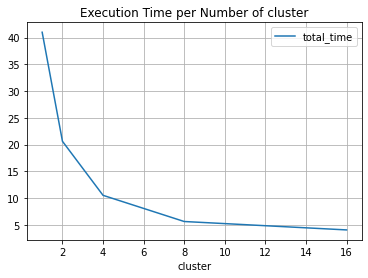

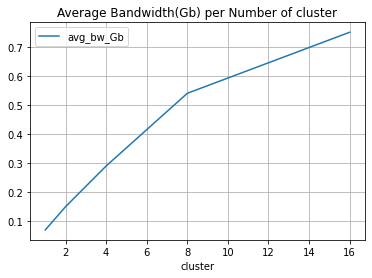

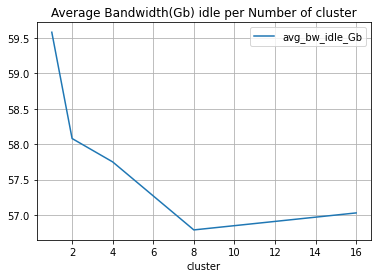

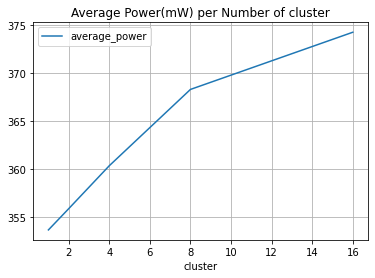

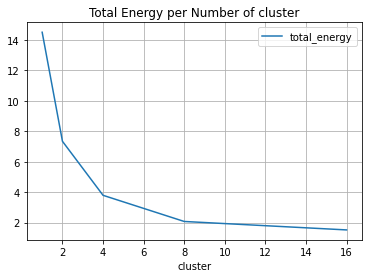

In [20]:
for input_file in input_files:
    default_file, main_file, file_list = start(input_file, paths_file)
    for file in file_list:
        run_cnn(file)
        conv_trace(file)
        run_dramsys(file)
        run_parser(file)
    group(main_file)
    plot(main_file)
